In [54]:
import pandas as pd
import numpy as np
import xarray as xr

import scipy.stats as stats
import matplotlib.pyplot as plt

In [35]:
# testing file
file = xr.open_dataset('/Users/victoriaford/Desktop/Train_Files/CAHYDRO_BROC1.nc') # has flagged vars
df = file.to_dataframe()
df = df.reset_index() 
df['month'] = pd.to_datetime(df['time']).dt.month # sets month to new variable
df['year'] = pd.to_datetime(df['time']).dt.year # sets year to new variable
# df

,station,time,tas,pr,tas_qc,elevation,lat,lon,month,year
0,CAHYDRO_BROC1,2010-05-30 15:30:00,300.940,NaN,nan,549.8592,33.2314,-116.4144,5,2010
1,CAHYDRO_BROC1,2010-05-31 15:20:00,301.490,NaN,nan,549.8592,33.2314,-116.4144,5,2010
2,CAHYDRO_BROC1,2010-06-05 15:20:00,303.160,NaN,nan,549.8592,33.2314,-116.4144,6,2010
3,CAHYDRO_BROC1,2010-06-06 15:25:00,304.830,NaN,nan,549.8592,33.2314,-116.4144,6,2010
4,CAHYDRO_BROC1,2010-06-12 15:25:00,294.830,NaN,nan,549.8592,33.2314,-116.4144,6,2010
...,...,...,...,...,...,...,...,...,...,...
2968,CAHYDRO_BROC1,2022-07-31 23:50:00,311.494,NaN,nan,549.8592,33.2314,-116.4144,7,2022
2969,CAHYDRO_BROC1,2022-08-06 23:20:00,315.383,NaN,nan,549.8592,33.2314,-116.4144,8,2022
2970,CAHYDRO_BROC1,2022-08-08 00:40:00,312.050,NaN,nan,549.8592,33.2314,-116.4144,8,2022
2971,CAHYDRO_BROC1,2022-08-21 00:20:00,310.939,NaN,nan,549.8592,33.2314,-116.4144,8,2022


    """
    Part 1 / monthly check
        - compare anomalies of monthly median values
        - standardize against interquartile range
        - compare stepwise from the middle of the distribution outwards
        - asymmetries are identified and flagged if severe
    Goal: identifies suspect months and flags all obs within month  
    """

In [197]:
def monthly_med(df):
    """Calculates the monthly median"""
    return df.resample('M', on='time').median(numeric_only=True)

def clim_med(df):
    """Calculates the climatological monthly median"""
    return df.groupby('month').median(numeric_only=True)

def iqr_range(df, month, var):
    """Calculates the monthly interquartile range"""
    q1 = df.groupby('month').quantile(0.25, numeric_only=True)
    q3 = df.groupby('month').quantile(0.75, numeric_only=True)
    iqr_df = q3 - q1
    
    iqr_val = iqr_df.loc[iqr_df.index == month]
    
    # inflated to 4°C or 4 hPa for months with very small IQR
    var_check = ['tas', 'tdps', 'tdps_derived', 'ps', 'psl', 'psl_altimeter']
    if iqr_val[var].values < 4:
        if var in var_check:
            iqr_val[var].values = 4
    
    return iqr_val[var].values

def standardized_anom(df, month, var):
    """
    Calculates the monthly anomalies standardized by IQR range
    
    Returns:
        arr_std_anom: array of monthly standardized anomalies for var
    """
    
    df_monthly_med = monthly_med(df)
    df_clim_med = clim_med(df)
    
    arr_anom = (df_monthly_med.loc[df_monthly_med['month'] == month][var].values -
                df_clim_med.loc[df_clim_med.index == month][var].values)
        
    arr_std_anom = arr_anom / iqr_range(df, month, var)
    
    return arr_std_anom
    
def standardized_median_bounds(df, month, var, thresh=5):
    """Calculates the standardized median"""
    std_med = np.median(sorted(standardized_anom(df, month, var)))
    
    lower_bnd = std_med - (thresh * iqr_range(df, month, var))
    upper_bnd = std_med + (thresh * iqr_range(df, month, var))
    
    return (std_med, lower_bnd[0], upper_bnd[0])

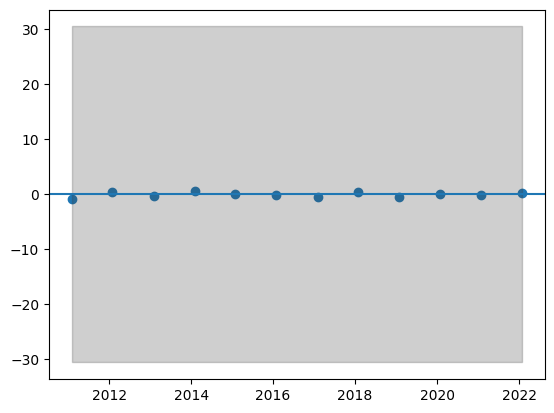

In [220]:
plt.scatter(x=df_monthly_med.loc[df_monthly_med['month'] == 1].index, y=standardized_anom(df, month=1, var='tas'))
plt.axhline(y=standardized_median_bounds(df, month=1, var='tas')[0])

plt.fill_between(x=df_monthly_med.loc[df_monthly_med['month'] == 1].index,
                y1=standardized_median_bounds(df, month=1, var='tas')[1],
                y2=standardized_median_bounds(df, month=1, var='tas')[2],
                alpha=0.25, color='0.25',
                label='5 * IQR range')

In [ ]:
def dist_gap_pt1_flag(df, var, month):
    
    # Calculate monthly climatological median
    df_clim_med = clim_med(df)
    
    # Calculate monthly medians
    df_allmon_med = monthly_med(df)
    
    # Standardize to IQR range
    med, low_bnd, high_bnd = standardized_median_bounds(df, month, var)
    
    # Identify months that are outside of range
    
    

In [223]:
standardized_anom(df, month=1, var='tas')

array([-0.95452315,  0.45476853, -0.4089645 ,  0.63634876,  0.08997219,
       -0.22738426, -0.54474072,  0.36316048, -0.45476853,  0.        ,
       -0.09111729,  0.27253394])

In [230]:
def flag_gross_outlier(arr, df, month, var, thresh=5):
    
    med, low_bnd, high_bnd = standardized_median_bounds(df, month, var, thresh=thresh)
    
    for i in arr:
        if (i < low_bnd) or (i > high_bnd):
            print(i , 'FLAGGED')
        else: print(i, 'PASSES')

In [231]:
flag_gross_outlier(standardized_anom(df, month=1, var='tas'), df, month=1, var='tas')

-0.9545231473908032
-0.9545231473908032 PASSES
0.4547685260919308
0.4547685260919308 PASSES
-0.40896450188124606
-0.40896450188124606 PASSES
0.6363487649272022
0.6363487649272022 PASSES
0.08997219041386464
0.08997219041386464 PASSES
-0.2273842630459747
-0.2273842630459747 PASSES
-0.544740716505814
-0.544740716505814 PASSES
0.3631604776705334
0.3631604776705334 PASSES
-0.4547685260919401
-0.4547685260919401 PASSES
0.0
0.0 PASSES
-0.09111729101914222
-0.09111729101914222 PASSES
0.27253394405365566
0.27253394405365566 PASSES


In [222]:
df_allmon_med = monthly_med(df)
df_allmon_med['tas']

time
2010-05-31    301.2150
2010-06-30    302.6100
2010-07-31    307.8850
2010-08-31    305.9400
2010-09-30    298.7200
                ...   
2022-04-30    302.0500
2022-05-31    306.4945
2022-06-30    312.3280
2022-07-31    311.7720
2022-08-31    312.3280
Freq: M, Name: tas, Length: 148, dtype: float64

In [ ]:
def dist_gap_pt1_plot(df, var, month):
    
    """should ultimately just read in the DF from flag function
    and plot scatter points of good vs/ bad months in bad years"""
    

    
    # Plot set-up
    mdded_c = 'k'
    iqr_c = '0.7'
    lw = 0.5
    alpha = 0.2
    
    # Plot data
    to_plot = df.plot.scatter(x='time', y=var) # data
    plt.axhline(y=med, label='Monthly median', color=med_c, lw=lw)
    plt.fill_between(x=df['time'],
                    y1=low_bnd,
                    y2=high_bnd,
                    alpha=alpha, color=iqr_c,
                    label='5 * IQR range')
    
    plt.legend(loc='upper right')
    plt.title('Distributional gap check pt 1: {} / Month: {}'.format(
    df['station'][0],
    month))
    
    return to_plot


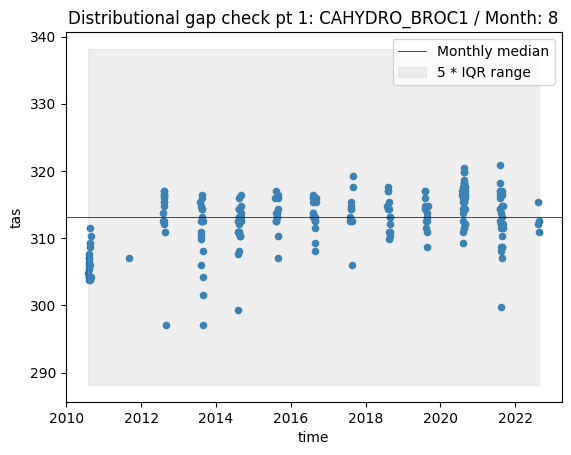

In [89]:
plot_clim_med = df_clim_med.loc[df_clim_med.index == 8]['tas'].values
iqr_5 = 5 * df_iqr.loc[df_iqr.index == 8]['tas'].values

test.plot.scatter(x='time', y='tas')
plt.axhline(y=plot_clim_med, label='Monthly median', color='k', lw=0.5)

# identify any month with a monthly median 5*iqr
med_iqr5_b = plot_clim_med - iqr_5 # below
med_iqr5_a = plot_clim_med + iqr_5 # above

# identify the IQR*5 range
plt.fill_between(x=test['time'], y1=med_iqr5_b, y2=med_iqr5_a, alpha=0.2, color='0.7', label='5 * IQR range')

plt.legend(loc='upper right');
plt.title('Distributional gap check pt 1: {} / Month: {}'.format(
    df['station'][0],
    '8'));

<Axes: xlabel='time', ylabel='tas'>

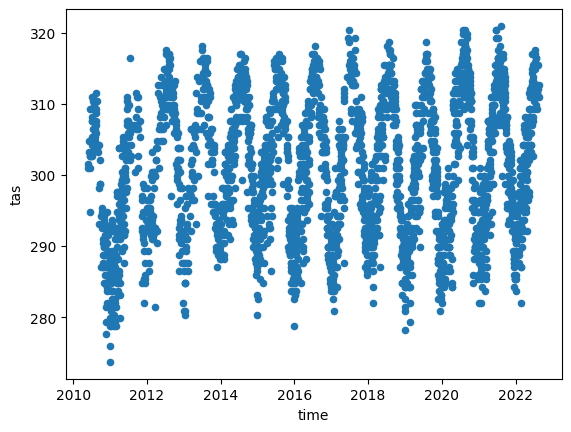

In [174]:
df.plot.scatter(x='time', y='tas')